<a href="https://colab.research.google.com/github/desultir/assign1/blob/master/MNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade scipy
!pip install --upgrade numpy


Requirement already up-to-date: scipy in /usr/local/lib/python3.6/dist-packages (1.2.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.16.2)


In [0]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import h5py
from google.colab import drive
import time


In [3]:
drive.mount('/content/drive')
with h5py.File('/content/drive/My Drive/Colab Notebooks/Input/train_128.h5','r') as H: 
  data = np.copy(H['data'])
with h5py.File('/content/drive/My Drive/Colab Notebooks/Input/train_label.h5','r') as H:
  label = np.copy(H['label'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

import pickle
import glob

model_dir = "/content/drive/My Drive/Colab Notebooks/Models/{}.pk"

def list_models():
  return glob.glob(model_dir.format("*"))

def load_model(name):
  with open(model_dir.format(name), 'rb') as f:
    return pickle.load(f)

def save_model(name, model):
  with open(model_dir.format(name), 'wb') as f:
    pickle.dump(model, f)

In [0]:
# need to normalize input data to avoid overflow/underflow in initial epochs
# normalize each feature independently
# options are zscore, minmax
def preprocess(input_array, method='zscore'):
  if method == 'zscore':
    for i in range(input_array.shape[1]):
      mean = np.mean(input_array[:, i])
      std = np.std(input_array[:, i])
      input_array[:, i] = (input_array[:, i] - mean) / std
  elif method == 'minmax':
    for i in range(input_array.shape[1]):
      # range 0 to max
      input_array[:, i] = (input_array[:, i] - np.min(input_array[:, i]))
      # range 0 to 2
      input_array[:, i] /= (np.max(input_array[:, i]) / 2)
      # range -1 to 1
      input_array[:, i] -= 1
      

In [0]:
#use stratified sampling to split train into train/validation
#this dataset is actually balanced but still good practice
def split(dataset, labels, train_percent=.85):
  count = len(dataset)
  num_classes = np.max(label) + 1
  train = []
  train_target = []
  validate = []
  validate_target = []
  for i in range(num_classes):
    class_data = np.ravel(np.argwhere(label == i))
    np.random.shuffle(class_data)
    cutoff = int(len(class_data) * train_percent)
    train_idx = class_data[:cutoff]
    val_idx = class_data[cutoff:]
    train.append(dataset[train_idx])
    train_target.append(labels[train_idx])
    validate.append(dataset[val_idx])
    validate_target.append(labels[val_idx])
    
  return np.vstack(train), np.hstack(train_target), np.vstack(validate), np.hstack(validate_target)

In [0]:
#need to one-hot encode labels to map to N output nodes (1 per class)
#ie convert each label into a (10,) vector where the relevant column is 1

def OHE(input_array, num_classes=10):
  output = []
  for x in input_array:
    output.append(np.zeros((10,)))
    output[-1][x] = 1
  return np.vstack(output)

In [0]:
def calc_MSE(y, y_hat):
  error = y-y_hat
  return np.mean(np.sum(error**2, axis=1))
  

In [0]:
class Activation(object):
    def tanh(self, x):
        return np.tanh(x)

    def tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.logistic
            self.f_deriv = self.logistic_deriv
        elif activation == 'tanh':
            self.f = self.tanh
            self.f_deriv = self.tanh_deriv

In [0]:

class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        self.W = np.random.normal(
                loc=0,
                scale=1,
                size=(n_in, n_out)
        )
        self.W *= 1/n_in
        if activation == 'relu':
            #relu
            self.W *= 2

        self.b = np.zeros(n_out,)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta, output_layer=False):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

In [0]:
class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'tanh','tanh']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
        error = y-y_hat
        loss=np.sum(error**2)
        # calculate the delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta
        
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                
                # backward pass
                loss[it],delta=self.criterion_MSE(y[i],y_hat)
                self.backward(delta)
                
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
            if not k % 10:
              print(".", end="")
        return to_return

    def predict(self, x):
        x = np.array(x)
        output = []
        for i in np.arange(x.shape[0]):
            output.append(nn.forward(x[i,:]))
        return np.vstack(output)

In [22]:
np.seterr(all="warn")
np.random.seed(1)
procdata = np.copy(data)
preprocess(procdata, 'zscore')

#split data
train, train_target, validate, validate_target = split(data, label)
#one hot encode targets
train_target = OHE(train_target, 10)
validate_target = OHE(validate_target, 10)

nn = MLP([128,60,10], [None,'logistic','tanh'])
start = time.time()
MSE = nn.fit(train, train_target, learning_rate=0.01, epochs=500)
print("{}s to train".format(time.time() - start))
print('loss:%f'%MSE[-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: underflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: underflow encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: underflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: underflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: underflow encountered in multiply


..................................................2532.476429462433s to train
loss:0.301357


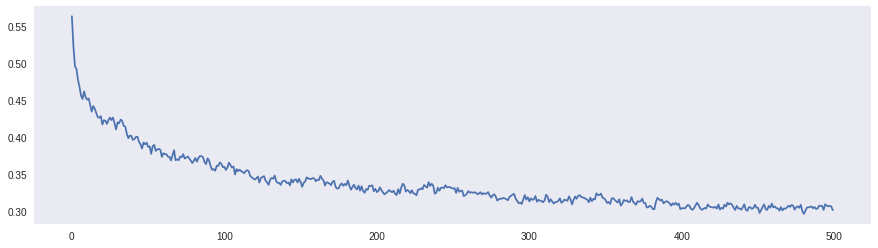

In [23]:
pl.figure(figsize=(15,4))
pl.plot(MSE)
pl.grid()

In [25]:
#get validation score
#nn = load_model("tdm1")
preds = nn.predict(validate)

loss = calc_MSE(preds, validate_target)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: underflow encountered in exp
  if __name__ == '__main__':


ValueError: ignored

In [0]:
save_model("tdm1")